图片

模型
cp /public/pytorch_models/vgg/ ~/.cache/torch/hub/checkpoints/

In [1]:
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

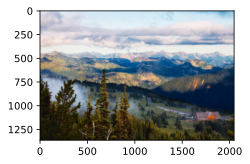

In [2]:
d2l.set_figsize()
content_img =  d2l.Image.open('../img/rainier.jpg')
d2l.plt.imshow(content_img);

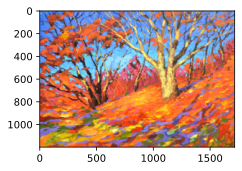

In [3]:
style_img = d2l.Image.open('../img/autumn-oak.jpg')
d2l.plt.imshow(style_img)

In [4]:
rgb_mean = torch.tensor((0.485, 0.456, 0.406))
rgb_std = torch.tensor((0.229, 0.224, 0.225))

def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_mean)
    ])
    return transforms(img).unsqueeze(0)

def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp( img.permute(1, 2, 0) * rgb_std + rgb_mean, 0 ,1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))


In [5]:
pretrained_net = torchvision.models.vgg19(weights=torchvision.models.VGG19_Weights.DEFAULT)

In [6]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]


In [7]:
pretrained_net.features[0]

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [8]:
net = nn.Sequential(*[pretrained_net.features[i] for i in range(max(content_layers + style_layers) + 1)])



In [9]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in content_layers:
            contents.append(X)
        if i in style_layers:
            styles.append(X)
    return contents, styles

In [10]:
def get_contents(image_shape, device):
    content_X =  preprocess(content_img,image_shape).to(device)
    content_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, content_Y

def get_style(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, style_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, style_Y


In [11]:
def content_loss(y_hat, y):
    return torch.square(y_hat - y.detach()).mean()

In [12]:
def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (n * num_channels)

def style_loss(y_hat, gram_y):
    return torch.square(gram(y_hat) - gram_y.detach()).mean()

In [13]:
def tv_loss(y_hat):
    return 0.5 * (torch.abs(y_hat[:, : , 1:, :] - y_hat[: , : , :-1, :]).mean() + 
                  torch.abs(y_hat[:, : , : ,1: ] - y_hat[:, : , : , :-1]).mean() )

In [14]:
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, style_Y_gram):
    contents_l = [content_loss(y_hat, y) * content_weight for
                   y_hat, y in zip(contents_Y_hat, contents_Y)]
    styles_l = [style_loss(y_hat, gram_y) * style_weight for y_hat, gram_y in zip(styles_Y_hat, style_Y_gram)]
    tv_l = tv_loss(X) * tv_weight

    l = sum(10 * styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

In [15]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super().__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

In [16]:
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    style_Y_gram = [gram(y) for y in styles_Y]
    return gen_img(), style_Y_gram, trainer

In [17]:
def train(X, contents_Y, styles_Y,device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[10, num_epochs], legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(
        X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        if (epoch+1)%10==0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch+1, [float(sum(contents_l)), float(sum(styles_l)), float(tv_l)])
    return X


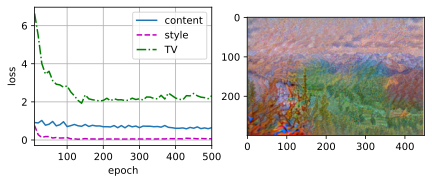

In [18]:
device, image_shape = d2l.try_gpu(), (300, 450)
net = net.to(device)

content_X, content_Y = get_contents(image_shape, device)
_,styles_Y = get_style(image_shape, device)


output = train(content_X, content_Y, styles_Y, device, 0.3, 500, 50)

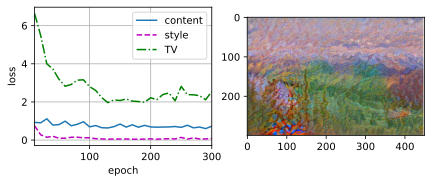

In [19]:
device, image_shape = d2l.try_gpu(), (300, 450)
net = net.to(device)

content_X, content_Y = get_contents(image_shape, device)
_,styles_Y = get_style(image_shape, device)


output = train(content_X, content_Y, styles_Y, device, 0.3, 300, 50)

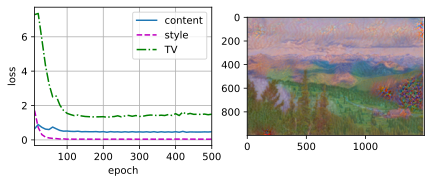

In [20]:
device, image_shape = d2l.try_gpu(), (1000, 1500)
net = net.to(device)

content_X, content_Y = get_contents(image_shape, device)
_,styles_Y = get_style(image_shape, device)


output = train(content_X, content_Y, styles_Y, device, 0.3, 500, 50)

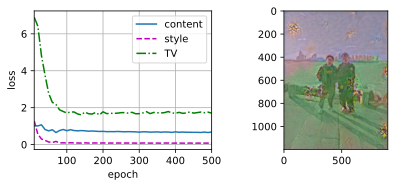

In [21]:
content_img =  d2l.Image.open('../img/person.jpg')
style_img = d2l.Image.open('../img/style.jpg')

device, image_shape = d2l.try_gpu(), (1200, 900)
net = net.to(device)

content_X, content_Y = get_contents(image_shape, device)
_,styles_Y = get_style(image_shape, device)


output = train(content_X, content_Y, styles_Y, device, 0.3, 500, 50)

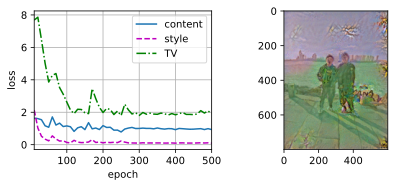

In [22]:
content_img =  d2l.Image.open('../img/person.jpg')
style_img = d2l.Image.open('../img/style.jpg')

device, image_shape = d2l.try_gpu(), (800, 600)
net = net.to(device)

content_X, content_Y = get_contents(image_shape, device)
_,styles_Y = get_style(image_shape, device)


output = train(content_X, content_Y, styles_Y, device, 0.3, 500, 50)